In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
import PIL
from PIL import Image
import random
from sklearn.decomposition import PCA
import scipy
import sklearn
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Dropout, Dense, Softmax)
from tensorflow.keras.applications import mobilenet as _mobilenet
import os
import networkx as nx
from sklearn.neighbors import NearestNeighbors
from IPython.display import Image as iImage
from IPython.display import display
import math
from scipy import spatial
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np

In [41]:
def normalise(train, p):
    min_d = np.min(train)
    max_d = np.max(train)
    normalised_p = (p-min_d)/(max_d - min_d)
    return normalised_p

def denormalise(train, p):
    min_d = np.min(train)
    max_d = np.max(train)
    denormalised_p = p * (max_d - min_d) + min_d
    return denormalised_p

def find_BMU(SOM,x):
    distSq = (np.square(SOM - x)).sum(axis=2)
    return np.unravel_index(np.argmin(distSq, axis=None), distSq.shape)

def update_weights(SOM, train_ex, learn_rate, radius_sq, 
                   BMU_coord, step=3):
    g, h = BMU_coord
    if radius_sq < 1e-3:
        SOM[g,h,:] += learn_rate * (train_ex - SOM[g,h,:])
        return SOM
    for i in range(max(0, g-step), min(SOM.shape[0], g+step)):
        for j in range(max(0, h-step), min(SOM.shape[1], h+step)):
            dist_sq = np.square(i - g) + np.square(j - h)
            dist_func = np.exp(-dist_sq / 2 / radius_sq)
            SOM[i,j,:] += learn_rate * dist_func * (train_ex - SOM[i,j,:])   
    return SOM    

def train_SOM(SOM, train_data, learn_rate = .1, radius_sq = 1, 
             lr_decay = .1, radius_decay = .1, epochs = 10):    
    learn_rate_0 = learn_rate
    radius_0 = radius_sq
    for epoch in np.arange(0, epochs):
        rand.shuffle(train_data)      
        for train_ex in train_data:
            g, h = find_BMU(SOM, train_ex)
            SOM = update_weights(SOM, train_ex, 
                                 learn_rate, radius_sq, (g,h))
        learn_rate = learn_rate_0 * np.exp(-epoch * lr_decay)
        radius_sq = radius_0 * np.exp(-epoch * radius_decay)            
    return SOM

def calculateQE(SOM,data):
    sumSqDist = 0
    for d in data:
        g,h = find_BMU(SOM, d)
        v1 = SOM[g,h]
        v2 = d
        sumSqDist += scipy.spatial.distance.cdist([v1],[v2],'sqeuclidean')[0][0]
    QE = sumSqDist/len(data)
    return QE

def find_BMU_2(SOM,x):
    distSq = (np.square(SOM - x)).sum(axis=2)
    return np.unravel_index(np.argpartition(distSq, 2, axis=None)[2], distSq.shape)

def calculateTE(SOM,data):
    failed = 0
    for d in data:
        g1,h1 = find_BMU(SOM,d)
        g2,h2 = find_BMU_2(SOM,d)
        dist = scipy.spatial.distance.cityblock([g1,h1], [g2,h2])
        if dist>1:
            failed+=1
    return failed/len(data)

def euclidean(a, b):
    return np.linalg.norm(a-b)

def u_matrix(lattice):
    """Builds a U-matrix on top of the trained lattice.

        Parameters
        ---
        lattice : list

            The SOM generated lattice

        Returns
        ---
        The lattice of the shape (R,C):

        R - number of rows; C - number of columns;
        """
    X, Y, Z = lattice.shape
    u_values = np.empty((X,Y), dtype=np.float64)

    for y in range(Y):
        for x in range(X):
            current = lattice[x,y]
            dist = 0
            num_neigh = 0
            # left
            if x-1 >= 0:
                #middle
                vec = lattice[x-1,y]
                dist += euclidean(current, vec)
                num_neigh += 1
                if y - 1 >= 0:
                    #sup
                    vec = lattice[x-1, y-1]
                    dist += euclidean(current, vec)
                    num_neigh += 1
                if y + 1 < Y:
                    # down
                    vec = lattice[x-1,y+1]
                    dist += euclidean(current, vec)
                    num_neigh += 1
            # middle
            if y - 1 >= 0:
                # up
                vec = lattice[x,y-1]
                dist += euclidean(current, vec)
                num_neigh += 1
            # down
            if y + 1 < Y:
                vec = lattice[x,y+1]
                dist += euclidean(current, vec)
                num_neigh += 1
            # right
            if x + 1 < X:
                # middle
                vec = lattice[x+1,y]
                dist += euclidean(current, vec)
                num_neigh += 1
                if y - 1 >= 0:
                    #up
                    vec = lattice[x+1,y-1]
                    dist += euclidean(current, vec)
                    num_neigh += 1
                if y + 1 < lattice.shape[1]:
                    # down
                    vec = lattice[x+1,y+1]
                    dist += euclidean(current, vec)
                    num_neigh += 1
            u_values[x,y] = dist / num_neigh
    u_values = (u_values - 1) * -1
    return u_values

def activate(train_data, SOM, p):
    normalP = normalise(train_data, p)
    activatedSOM = np.array([[euclidean(normalP, c) for c in r] for r in SOM])
    normalisedActivatedSOM = normalise(activatedSOM, activatedSOM)
    activatedSOM = (normalisedActivatedSOM -1)*(-1)
    return activatedSOM

def load_image(img_file, target_size=(224,224)):
    X = np.zeros((1, *target_size, 3))
    X[0, ] = np.asarray(tf.keras.preprocessing.image.load_img(
        img_file, 
        target_size=target_size)
    )
    X = tf.keras.applications.mobilenet.preprocess_input(X)
    return X

def ensure_folder_exists(folder):
    if not os.path.exists(folder):
        os.makedirs(folder)

def processImage(imagePath, model):
    im = load_image(imagePath)
    f = model.predict(im)[0]
    return f

def img_reshape(img):
    img = Image.open('MOMAimages/'+img).convert('RGB')
    img = img.resize((100,100))
    img = np.asarray(img)
    return img

# homework  1-  Train a SOM with your own collection of images. 

In [3]:
model = tf.keras.applications.mobilenet.MobileNet(
# The 3 is the three dimensions of the input: r,g,b.
  input_shape=(224, 224, 3), 
  include_top=False, 
  pooling='avg'
)

In [4]:
imageFiles = os.listdir(r"E:\term2\SOM\111")
imageFiles = [f for f in imageFiles if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
features = []
for m in imageFiles:
    path = os.path.join(r"E:\term2\SOM\111", m)
    f = processImage(path, model)
    features.append(f)

featureImagePairs = []
for i in range(len(features)):
    featureImage = {'image': imageFiles[i], 'feature': features[i]}
    featureImagePairs.append(featureImage)
featureImagePairs[0]

1/1 [==============================] - 0s 29ms/step


{'image': '1.jpg',
 'feature': array([0.        , 2.5727994 , 0.3513388 , ..., 0.9816756 , 0.        ,
        0.07944712], dtype=float32)}

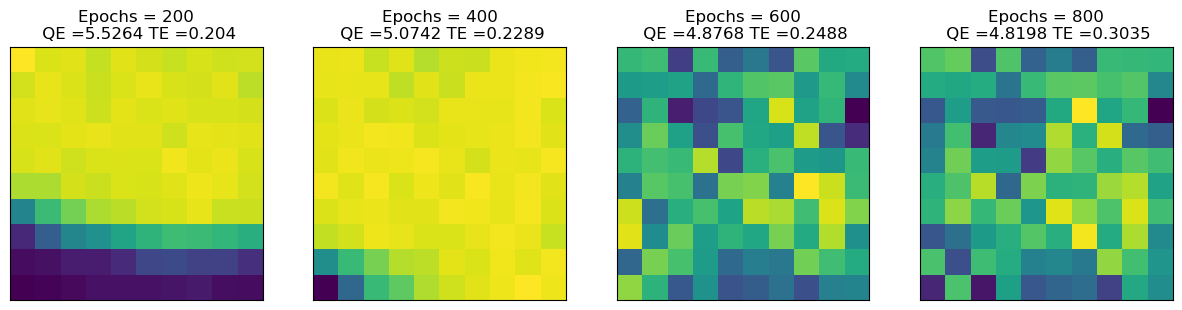

In [10]:
m = 10
n = 10
n_x = 200
rand = np.random.RandomState(0)

train_data = features

n_train_data = normalise(train_data, train_data)
SOM = rand.uniform(0, 1, (m, n, len(train_data[0])))

fig, ax = plt.subplots(
    nrows=1, ncols=4, figsize=(15, 3.5), 
    subplot_kw=dict(xticks=[], yticks=[]))
total_epochs = 0
SOMS = []
for epochs, i in zip([200, 200, 200, 200], range(0,4)):
    total_epochs += epochs
    SOM = train_SOM(SOM, n_train_data, learn_rate = .1, radius_sq = 2, epochs = epochs)
    SOMS.append(SOM)
    QE = round(calculateQE(SOM, n_train_data), 4)
    TE = round(calculateTE(SOM, n_train_data), 4)
    
    ax[i].imshow(u_matrix(SOM))
    ax[i].title.set_text('Epochs = ' + str(total_epochs) + '\n QE =' + str(QE) + ' TE =' + str(TE))

In [ ]:
SOM = SOMS[-1]

# homework  4-  make sure that the images that are displayed are in fact the images that are closest to the SOM vector

In [21]:
SOMimages = []
for i in range(len(SOM)):
    row = []
    for j in range(len(SOM[0])):
        row.append([])
    SOMimages.append(row)

def find_BMU_mindist(SOM, x):
    distSq = np.square(SOM - x).sum(axis=2)
    min_dist_index = np.argmin(distSq, axis=None)  
    min_dist = np.sqrt(distSq.flatten()[min_dist_index])  
    return np.unravel_index(min_dist_index, distSq.shape), min_dist

for fi in featureImagePairs:
    (g, h), dist = find_BMU_mindist(SOM, normalise(train_data, fi['feature']))
    fi['distance'] = dist  
    SOMimages[g][h].append(fi)

for g in range(len(SOMimages)):
    for h in range(len(SOMimages[g])):
        SOMimages[g][h] = sorted(SOMimages[g][h], key=lambda x: x['distance'])
    

# homework  5-  Write a function that returns a grid of images where each image is the closest image from the training data set to that cell in the SOM.

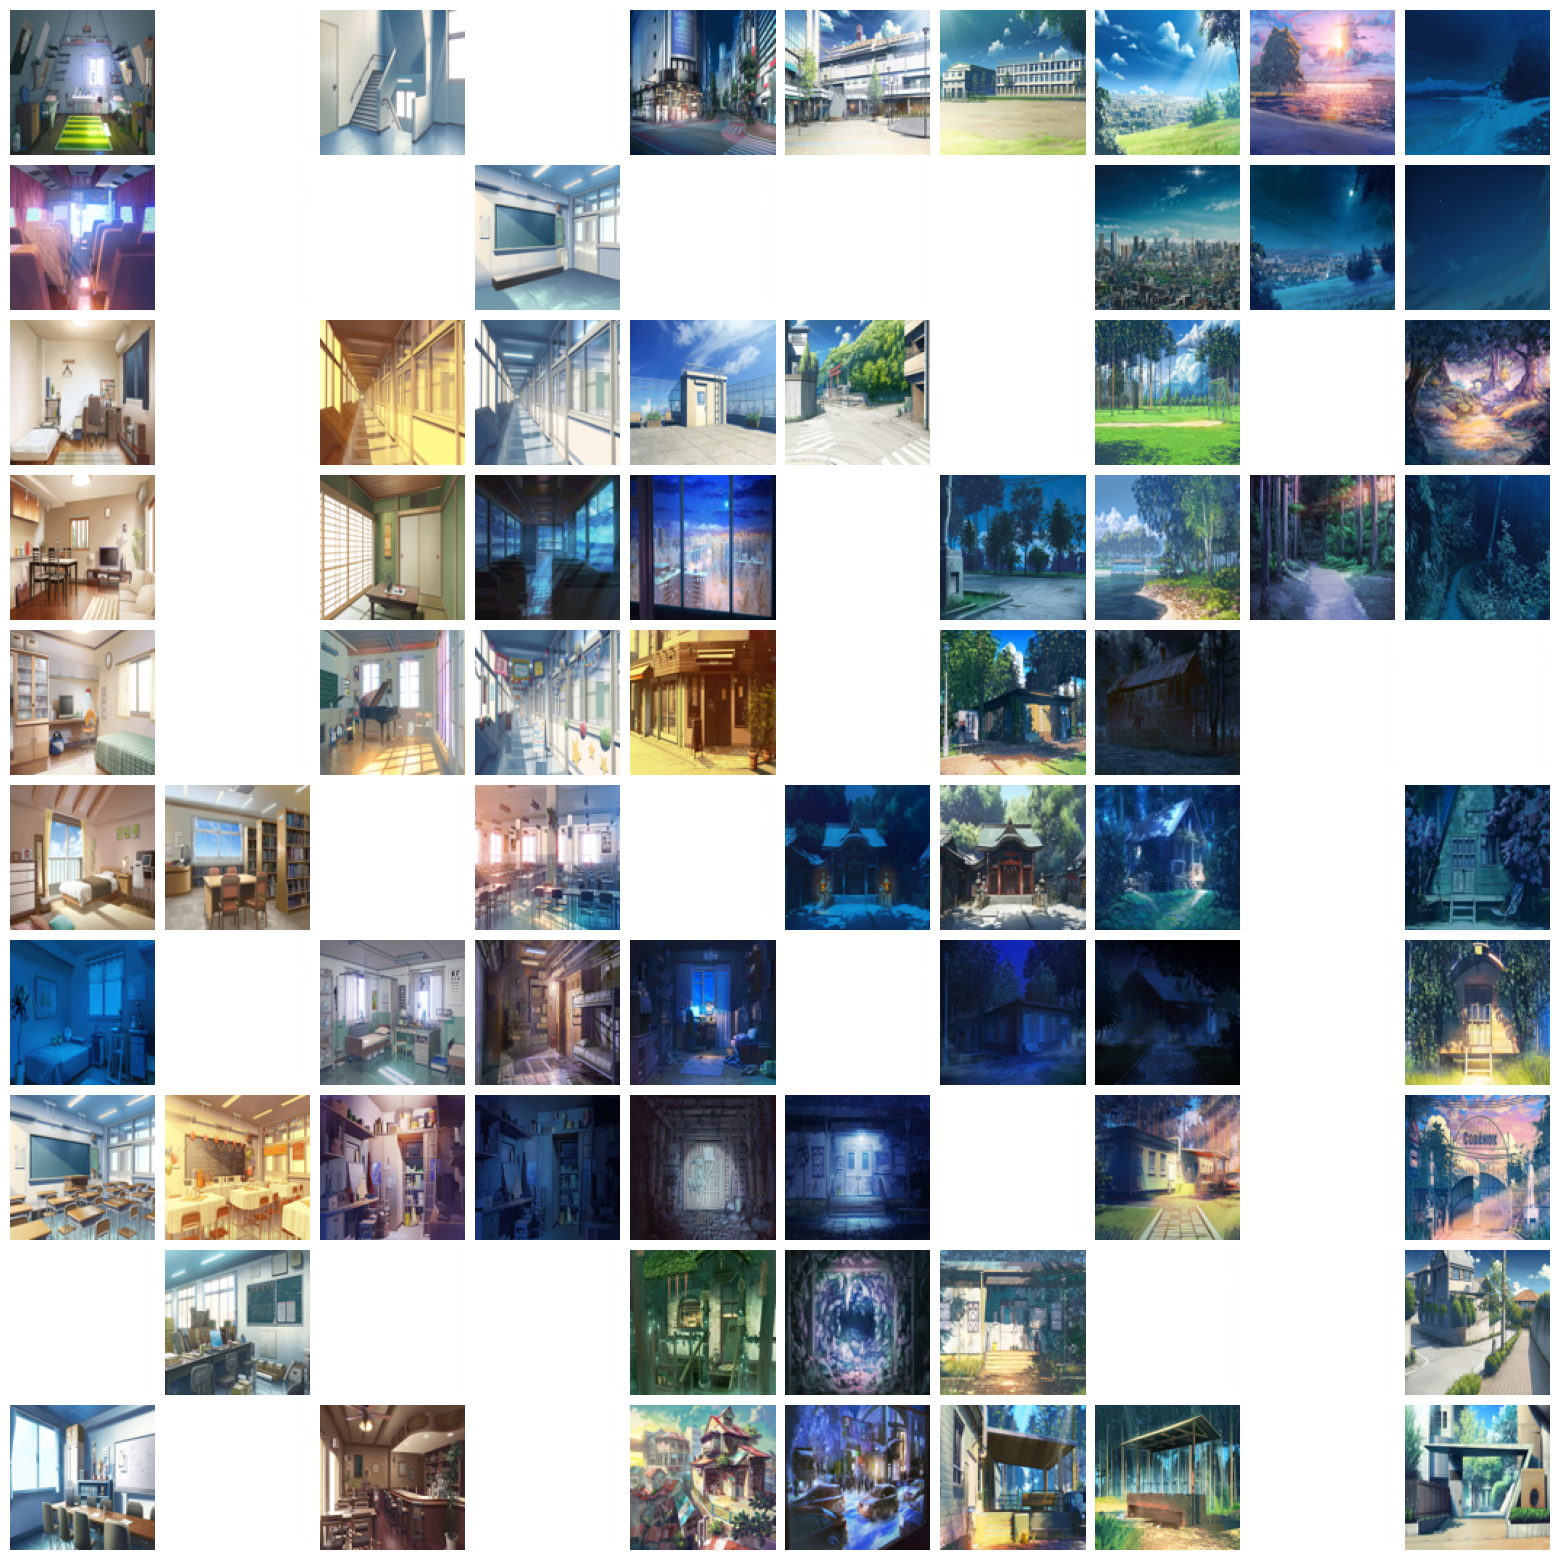

In [25]:
def create_image_grid(SOMimages, default_image='white.png'):
    imageGrid = []
    for row in SOMimages:
        for cell in row:
            image_filename = cell[0]['image'] if len(cell) > 0 else default_image
            imageGrid.append(image_filename)
    
    return imageGrid


def img_reshape(img, image_folder_path, default_image='white.png', target_size=(100,100)):
    try:
        img_path = os.path.join(image_folder_path, img)
        image = Image.open(img_path).convert('RGB')
    except FileNotFoundError:
        img_path = os.path.join(image_folder_path, default_image)
        image = Image.open(img_path).convert('RGB')
    image = image.resize(target_size)
    return np.asarray(image)


def display_images_from_grid(imageGrid, image_folder_path, grid_dimensions=(10, 10), default_image='white.png'):
    img_arr = [img_reshape(image, image_folder_path, default_image) for image in imageGrid]

    fig = plt.figure(figsize=(20., 20.))
    grid = ImageGrid(fig, 111, nrows_ncols=grid_dimensions, axes_pad=0.1)

    for ax, im in zip(grid, img_arr):
        ax.imshow(im)
        ax.axis('off')
    plt.show()


image_folder_path = r'E:\term2\SOM\111'  
display_images_from_grid(imageGrid, image_folder_path)

# homework  2-  Write a function with which you can save a trained som using pickle

In [16]:
import pickle

def save_som_model(som_model, file_path):
    with open(file_path, 'wb') as file:  
        pickle.dump(som_model, file)

    print(f"Model saved to {file_path}")

trained_som = SOM 
save_som_model(trained_som, r"E:\term2\SOMS\trained_som.pkl")

Model saved to E:\term2\SOMS\trained_som.pkl


# homework  3-  Write a function to load a saved som

In [17]:
def load_som_model(file_path):
    with open(file_path, 'rb') as file:  
        som_model = pickle.load(file)
    
    return som_model

file_path = r"E:\term2\SOMS\trained_som.pkl"
trained_som = load_som_model(file_path)

# homework  6-  Make a function to visualise a uMatrix using your own colour gradient

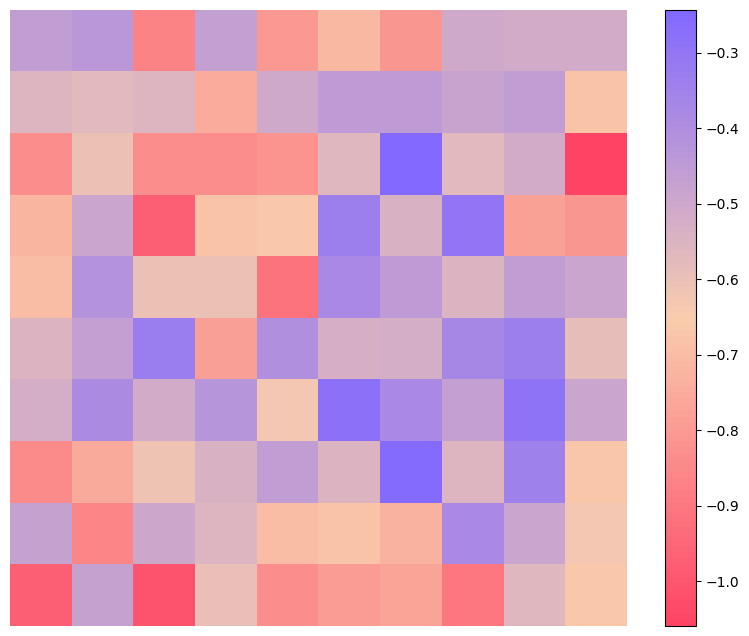

In [39]:
from matplotlib.colors import LinearSegmentedColormap

def visualize_u_matrix(som_lattice, colormap):

    u_mat = u_matrix(som_lattice)  
    plt.figure(figsize=(10, 8))
    plt.imshow(u_mat, cmap=colormap)
    plt.colorbar()  
    plt.axis('off')  
    plt.show()


colors = [(254/255, 67/255, 101/255), (249/255, 205/255, 173/255), (131/255, 105/255, 255/255)]
cmap_name = 'myGradient'

cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=100)

visualize_u_matrix(SOM, cm)
